In [88]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
from keras.regularizers import l2, activity_l2
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

# Behavioral cloning using Deep Learning

In [89]:
# Load testdata
ds = np.load('traindata_large.npz')
print(ds.files)
observations = ds['observations']
actions = ds['actions'][:, 0]

['observations', 'actions']


In [91]:
# Data shape
num_inputs = observations.shape[1]
num_outputs = actions.shape[1]

In [92]:
# Train Validation and Test split
X, X_test, y, y_test = train_test_split(observations, actions, test_size=0.10, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

In [93]:
# Standardize make into function
mean = X_train.mean(axis=0)
X_train -= mean
std = X_train.std(axis=0)
X_train /= std

X_val -= mean
X_val /= std

X_test -= mean
X_test /= std

In [94]:
#Needed because of bug in keras 1.2.1 remove after update
from keras.wrappers.scikit_learn import BaseWrapper
import copy

def custom_get_params(self, **params):
    res = copy.deepcopy(self.sk_params)
    res.update({'build_fn': self.build_fn})
    return res

BaseWrapper.get_params = custom_get_params

In [62]:
def baseline_model():
    model = Sequential()
    model.add(Dense(num_inputs/2, input_dim=num_inputs, init='normal', activation='relu'))
    model.add(Dense(num_outputs, init='normal'))
    
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

model = baseline_model()

In [52]:
def regularized_model():
    model = Sequential()
    model.add(Dense(64, input_dim=num_inputs, init='normal', activation='relu',W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01),b_regularizer=l2(0.01)))
    model.add(Dense(64, input_dim=num_inputs, init='normal', activation='relu',W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01),b_regularizer=l2(0.01)))
    model.add(Dense(num_outputs, init='normal',W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01),b_regularizer=l2(0.01)))
    
    model.compile(loss='mse', optimizer='adam')
    return model
model = regularized_model()
history = model.fit(X_train, y_train, verbose=False, nb_epoch=50, batch_size=10000, validation_data=(X_val, y_val))

In [90]:
def wide_model():
    model = Sequential()
    model.add(Dense(128, input_dim=num_inputs, init='normal', activation='relu'))
    model.add(Dense(num_outputs, init='normal'))

    model.compile(loss='mse', optimizer='adam')
    return model
model = wide_model()

In [95]:
history = model.fit(X_train, y_train, verbose=False, nb_epoch=10, batch_size=10000, validation_data=(X_val, y_val))

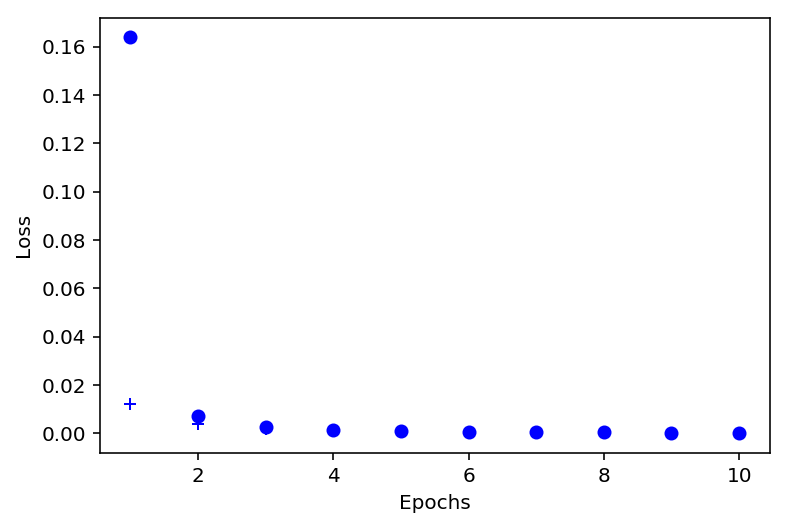

In [96]:
history_dict = history.history
acc_values = history_dict['loss']
val_acc_values = history_dict['val_loss']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'bo')
plt.plot(epochs, val_acc_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [97]:
# Retrain model on all data with the right hyperparams
model.fit(X, y, verbose=False, nb_epoch=10, batch_size=10000)

In [98]:
# Test on test data
results = model.evaluate(X_test, y_test)
results

 999904/1000000 [============================>.] - ETA: 0s  

67.576447053344722

In [68]:
import gym

def policy_fn(obs):
    #Make prediction using standized data
    obs -= mean
    obs /= std
    action = model.predict(obs[None,:])
    #Cap the range to -.4 to +.4
    np.clip(action, -.4, .4, out=action)
    return action[:,None].T
    

envname = 'Hopper-v1'
num_rollouts = 2

env = gym.make(envname)
max_steps = env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')#env.spec.timestep_limit

returns = []
observations = []
actions = []
for i in range(num_rollouts):
    print('iter', i)
    obs = env.reset()
    done = False
    totalr = 0.
    steps = 0
    while not done:
        action = policy_fn(obs)
        observations.append(obs)
        actions.append(action)
        obs, r, done, _ = env.step(action)
        totalr += r
        steps += 1
        if True:
            env.render()
        if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
        if steps >= max_steps:
            env.render(close=True)
            break
    returns.append(totalr)


print('returns', returns)
print('mean return', np.mean(returns))
print('std of return', np.std(returns))

[2017-02-11 21:37:46,321] Making new env: Hopper-v1


('iter', 0)
100/1000
200/1000
300/1000
('iter', 1)
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
('returns', [557.70950419418216, 1114.9935767339368])
('mean return', 836.35154046405955)
('std of return', 278.64203626987734)


# Imitation learning using Dagger

In [85]:
# Train a model on one rollout
ds = np.load('traindata.npz')
observations = ds['observations']
actions = ds['actions'][:, 0]

# Standardize make into function
mean = observations.mean(axis=0)
adj_observations = observations - mean
std = observations.std(axis=0)
adj_observations /= std

In [86]:
model.fit(adj_observations, actions, verbose=False, nb_epoch=10, batch_size=25)

In [87]:
import load_policy
import tensorflow as tf
#import tf_util
#Run dagger
print('loading and building expert policy')
expert_policy_fn = load_policy.load_policy('experts/Hopper-v1.pkl')
print('loaded and built')

import gym

def policy_fn(obs):
    #Make prediction using standized data
    obs -= mean
    obs /= std
    action = model.predict(obs[None,:])
    #Cap the range to -.4 to +.4
    np.clip(action, -.4, .4, out=action)
    return action[:,None].T
    

envname = 'Hopper-v1'
num_rollouts = 10000

env = gym.make(envname)
max_steps = env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')#env.spec.timestep_limit

session = tf.InteractiveSession()
init_op = tf.global_variables_initializer()
session.run(init_op)
steps = 0
for i in range(num_rollouts):
    returns = []
    observationss = []
    obs = env.reset()
    done = False
    totalr = 0.
    steps += 1
    while not done:
        policy_fn(obs)
        observationss.append(obs)
        obs, r, done, _ = env.step(action)
        totalr += r
        if False:
            env.render()
        if steps >= max_steps:
            #env.render(close=True)
            break
    returns.append(totalr)

    if steps % 10 == 0: print('Return', totalr)
    

    #2: Query expert on correct actions
    actionss = []
    for o in observationss:
        action = expert_policy_fn(o[None,:])
        actionss.append(action)

    #3: Merge old observations and actions into one dataset
    actions = np.concatenate((actions, np.array(actionss)[:, 0]),axis=0)
    observations = np.concatenate((observations, observationss),axis=0)

    #4: Retrain policy 
    mean = observations.mean(axis=0)
    adj_observations = observations - mean
    std = observations.std(axis=0)
    adj_observations /= std
    model.fit(adj_observations, actions, verbose=False, nb_epoch=20, batch_size=25)

session.close()

[2017-02-11 21:54:48,491] Making new env: Hopper-v1


loading and building expert policy
('obs', (1, 11), (1, 11))
loaded and built
('Return', -1.2930711364284542)
('Return', -2.0625860983100508)
('Return', -0.98058235217652312)
('Return', -0.059496407058668099)
('Return', 101.06589523072638)
('Return', 2.9042588427801124)
('Return', -1.4156039191797589)
('Return', 38.238677505787543)
('Return', 2.9267842299509987)
('Return', -1.9399508892259161)
('Return', 38.193426160937868)
('Return', 2.9034139274980673)
('Return', -2.1345873651036258)
('Return', 38.050864297479677)
('Return', 2.9270572924117415)
('Return', -2.2104836853477812)
('Return', 37.766023028184591)
('Return', 2.9361129966538195)
('Return', -1.3329168483961373)
('Return', 37.898604234925592)
('Return', 2.945521748792145)
('Return', -1.6676017822117242)
('Return', 38.295197946438435)
('Return', 2.8858294898762304)


KeyboardInterrupt: 